In [1]:
import torch
import matplotlib.pyplot as plt
from utils.plots import plot_tensors, plot_tensor
from PIL import Image
import torch
import torchvision.transforms as transforms

In [2]:
n = 5
tau = 4.0
beta = 5.1
templates = []
for i in range(n):
    for j in range(n):
        t = torch.full((n, n), -tau)
        for x in range(n):
            for y in range(n):
                dist = abs(x - i) + abs(y - j)
                t[x, y] = tau * max(1 - beta * dist / n, -1)
        templates.append(t)
templates = torch.stack(templates)

#normalize
templates = templates - templates.min()
templates = templates / templates.max()

In [3]:
templates.shape

torch.Size([25, 5, 5])

/Users/valentinaferuere/Projects/interpretability/utils/plots.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


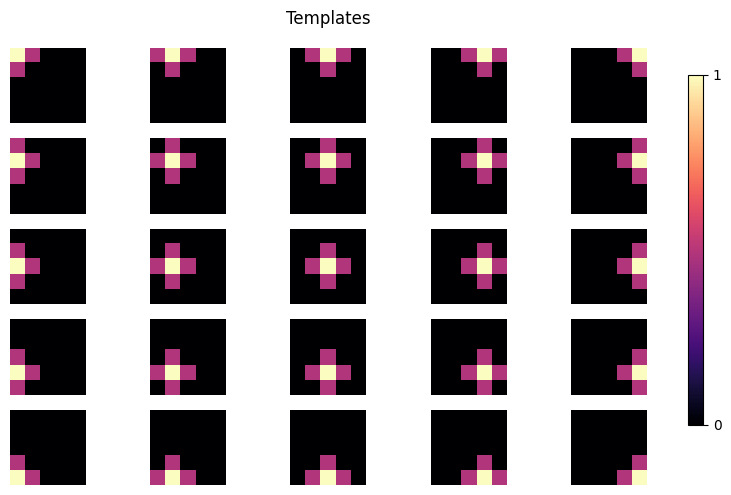

In [4]:
plot_tensors(templates.unsqueeze(0), title="Templates")

In [5]:
templates[20]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4900, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.4900, 0.0000, 0.0000, 0.0000]])

In [191]:
t = templates[4]
image = Image.open("examples/lightening_5x5_4.png")
t_image = transforms.ToTensor()(image).squeeze(0)
image_inverted = Image.open("examples/lightening_5x5_5.png")
t_image_inverted = transforms.ToTensor()(image_inverted).squeeze(0)
X = torch.stack([t_image, t_image_inverted])

In [192]:
print(t.shape)
print(t_image.shape)

torch.Size([5, 5])
torch.Size([5, 5])


In [193]:
t

tensor([[0.0000, 0.0000, 0.0000, 0.4900, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.4900],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

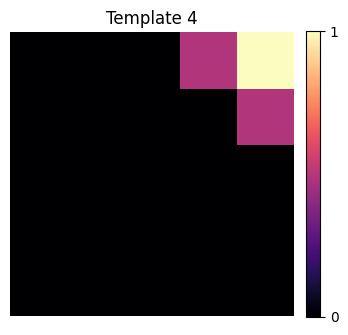

In [194]:
plot_tensor(t.unsqueeze(2), title="Template 4")

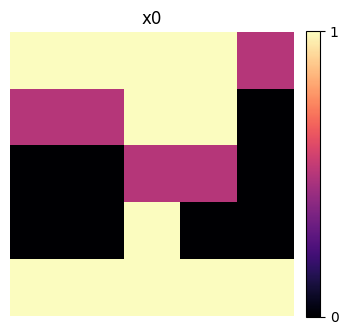

In [195]:
plot_tensor(t_image.unsqueeze(0).permute(1, 2, 0), title="x0")

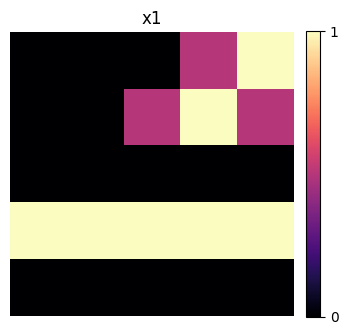

In [196]:
plot_tensor(t_image_inverted.unsqueeze(0).permute(1, 2, 0), title="x1")

In [197]:
tr_x_t = torch.mul(t.unsqueeze(0), t_image.unsqueeze(0))
tr_x_t.shape

torch.Size([1, 5, 5])

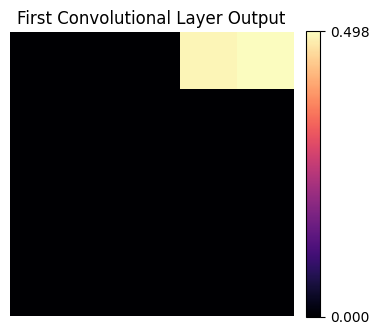

In [198]:
plot_tensor(tr_x_t.permute(1, 2, 0), title="First Convolutional Layer Output")

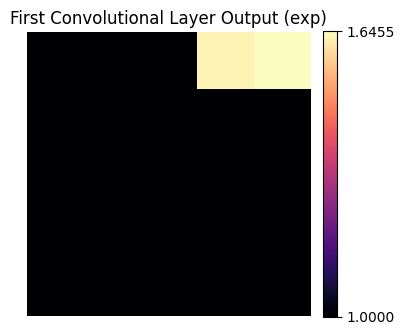

In [199]:
exp = torch.exp(tr_x_t)
plot_tensor(exp.permute(1, 2, 0), title="First Convolutional Layer Output (exp)")

In [200]:
print(X.shape)
print(templates.shape)

torch.Size([2, 5, 5])
torch.Size([25, 5, 5])


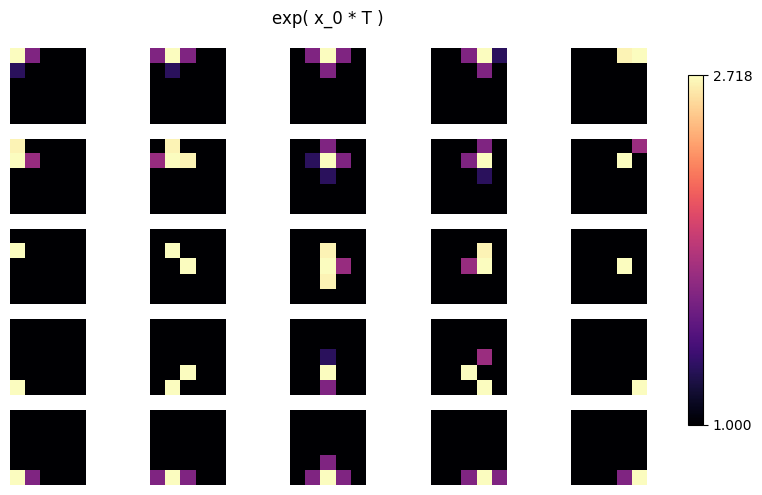

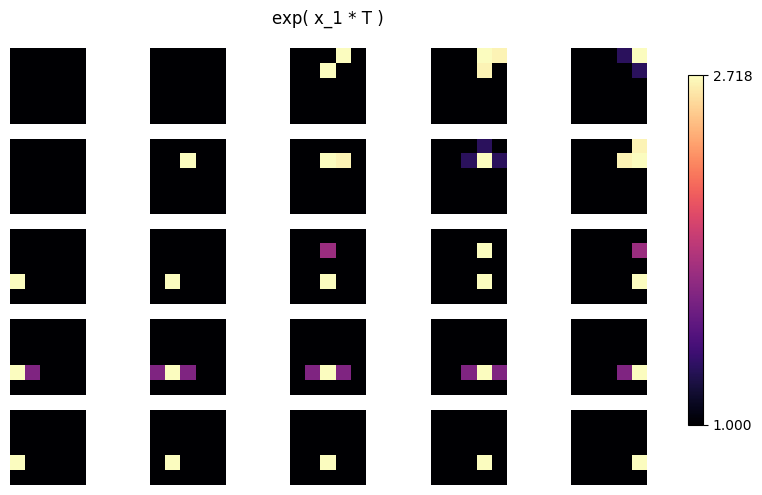

In [201]:
tr_x_ts = []
for x_i in range(X.shape[0]):
    tr_x_t = torch.exp(torch.mul(templates, X[x_i].unsqueeze(0)))
    tr_x_ts.append(tr_x_t)
    plot_tensors(tr_x_t.unsqueeze(0), title=f"exp( x_{x_i} * T )")

In [202]:
Z = torch.stack(tr_x_ts).sum(dim=0)
Z.shape

torch.Size([25, 5, 5])

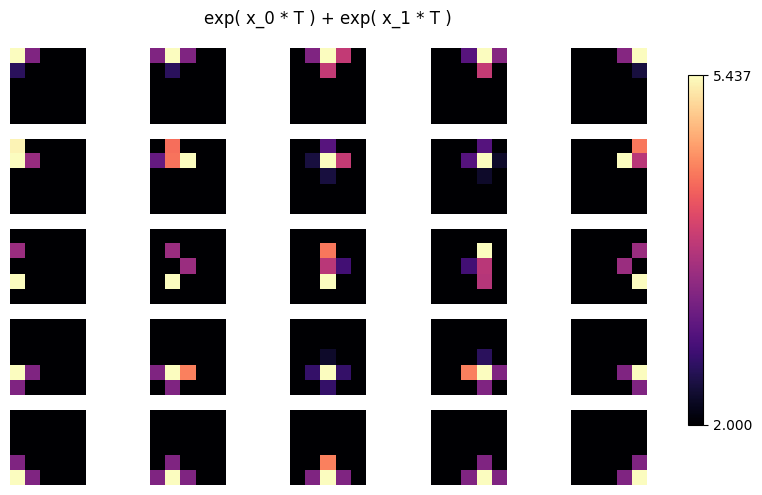

In [203]:
plot_tensors(Z.unsqueeze(0), title="exp( x_0 * T ) + exp( x_1 * T )")

In [204]:
p_x0_T = (1 / Z) * tr_x_ts[0]
p_x0_T.shape

torch.Size([25, 5, 5])

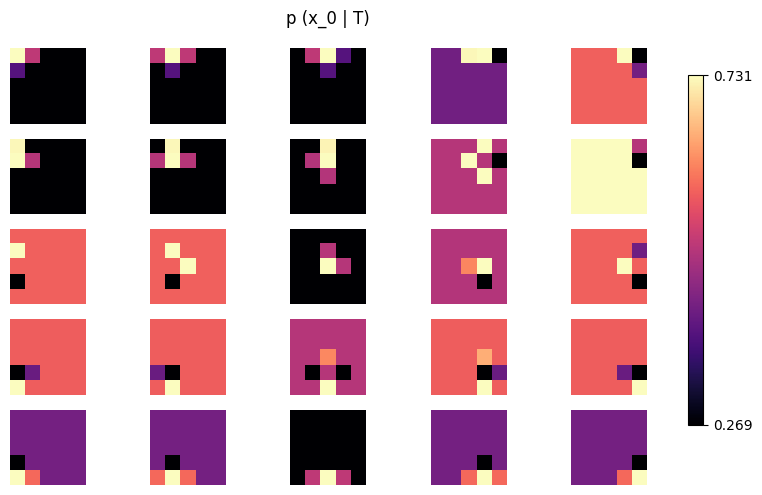

In [205]:
plot_tensors(p_x0_T.unsqueeze(0), title="p (x_0 | T)")

In [206]:
print(X.shape)
print(templates.shape)

torch.Size([2, 5, 5])
torch.Size([25, 5, 5])


In [207]:
templates.unsqueeze(1).shape

torch.Size([25, 1, 5, 5])

In [208]:
def calculate_p_x_T(X, templates):
    tr_x_ts = torch.exp(torch.mul(templates.unsqueeze(0), X.unsqueeze(1)))
    Z = tr_x_ts.sum(dim=(0))
    p_x_T = (1 / Z) * tr_x_ts
    return p_x_T

In [209]:
calculate_p_x_T(X, templates)

tensor([[[[0.7311, 0.6201, 0.5000, 0.5000, 0.5000],
          [0.5607, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         [[0.6201, 0.7311, 0.6201, 0.5000, 0.5000],
          [0.5000, 0.5607, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         [[0.5000, 0.6201, 0.7311, 0.5612, 0.5000],
          [0.5000, 0.5000, 0.5612, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],

         ...,

         [[0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
          [0.5000, 0.5000, 0.5000, 0.5000, 

In [210]:
def calculate_p_x_T(X, templates):
    tr_x_ts = torch.exp(torch.mul(templates.unsqueeze(1), X.unsqueeze(2)))
    Z = tr_x_ts.sum(dim=(0))
    p_x_T = (1 / Z) * tr_x_ts
    return p_x_T

In [211]:
def mutual_information(X, templates):
    n = templates.shape[-1]
    filters = X.shape[0]

    p_x_T_extended = calculate_p_x_T(X, templates)
    p_X = 1 / (n*n + 1)
    sum_p_T = p_X * (n*n)
    sum_p_X = sum_p_T * p_x_T_extended.sum(dim=(2))
    p_x_T = p_x_T_extended.sum(dim=(1, 2))
    mi = - sum_p_X.sum(dim=(1)) * p_x_T * torch.log((p_x_T) / (sum_p_X)).sum(dim=(1))
    return mi.sum()

In [212]:
print(X.shape, templates.shape)

torch.Size([2, 5, 5]) torch.Size([25, 5, 5])


In [213]:
X[0, :, :].shape

torch.Size([5, 5])

In [214]:
mutual_information(X[0, :, :].unsqueeze(0).unsqueeze(0), templates.unsqueeze(0))

tensor(-589.2529)

In [215]:
mutual_information(X[1, :, :].unsqueeze(0).unsqueeze(0), templates.unsqueeze(0))

tensor(-589.2529)

In [216]:
X[0, :, :]

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 0.4980],
        [0.4980, 0.4980, 1.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.4980, 0.4980, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]])

In [217]:
X[1]

tensor([[0.0000, 0.0000, 0.0000, 0.4980, 1.0000],
        [0.0000, 0.0000, 0.4980, 1.0000, 0.4980],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]])

In [218]:
X_ = (X[0].unsqueeze(0).unsqueeze(0))
X_

tensor([[[[1.0000, 1.0000, 1.0000, 1.0000, 0.4980],
          [0.4980, 0.4980, 1.0000, 1.0000, 0.0000],
          [0.0000, 0.0000, 0.4980, 0.4980, 0.0000],
          [0.0000, 0.0000, 1.0000, 0.0000, 0.0000],
          [1.0000, 1.0000, 1.0000, 1.0000, 1.0000]]]])

In [219]:
templates_ = (templates.unsqueeze(0))  # Ensure templates are also binary
templates_

tensor([[[[1.0000, 0.4900, 0.0000, 0.0000, 0.0000],
          [0.4900, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.4900, 1.0000, 0.4900, 0.0000, 0.0000],
          [0.0000, 0.4900, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.4900, 1.0000, 0.4900, 0.0000],
          [0.0000, 0.0000, 0.4900, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.4900, 1.0000, 0.4900],
          [0.0000, 0.0000, 0.0000, 0.4900, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      

In [220]:
X.sum()

tensor(22.9843)

In [221]:
(X_.matmul(templates_) + 1e-10) / torch.exp((X_.sum() / n*n) * (templates_.sum() / n*n) - 1e-10)

tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0

In [222]:
X_.matmul(templates_)

tensor([[[[1.4900, 0.4900, 0.0000, 0.0000, 0.0000],
          [0.7421, 0.2440, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.4900, 0.4900, 0.0000, 0.0000, 0.0000]],

         [[0.4900, 1.4900, 0.4900, 0.0000, 0.0000],
          [0.2440, 0.7421, 0.2440, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4900, 1.4900, 0.4900, 0.0000, 0.0000]],

         [[0.0000, 0.4900, 1.4900, 0.4900, 0.0000],
          [0.0000, 0.2440, 0.7421, 0.2440, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4900, 1.4900, 0.4900, 0.0000]],

         [[0.0000, 0.0000, 0.4900, 1.4900, 0.4900],
          [0.0000, 0.0000, 0.2440, 0.7421, 0.2440],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
      

In [223]:
torch.log2((X_.matmul(templates_) + 1e-10) / ((X_.sum() / n*n) * (templates_.sum() / n*n) + 1e-10))

tensor([[[[ -9.2862, -10.8907, -43.0808, -43.0808, -43.0808],
          [-10.2919, -11.8963, -43.0808, -43.0808, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [ -9.2862, -10.8907, -43.0808, -43.0808, -43.0808]],

         [[-10.8907,  -9.2862, -10.8907, -43.0808, -43.0808],
          [-11.8963, -10.2919, -11.8963, -43.0808, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [-10.8907,  -9.2862, -10.8907, -43.0808, -43.0808]],

         [[-43.0808, -10.8907,  -9.2862, -10.8907, -43.0808],
          [-43.0808, -11.8963, -10.2919, -11.8963, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [-43.0808, -43.0808, -43.0808, -43.0808, -43.0808],
          [-43.0808, -10.8907,  -9.2862, -10.8907, -43.0808]],

         [[-43.0808, -43.0808, -10.8907,  -9.2862, -10.8907],
  

In [224]:
MI = (X_.matmul(templates_)) * torch.log2((X_.matmul(templates_) + 1e-10) / ((X_.sum() / n*n) * (templates_.sum() / n*n) + 1e-10))
MI.sum() / (n*n)

tensor(-75.2956)

In [225]:
X_.matmul(templates_).shape

torch.Size([1, 25, 5, 5])

In [226]:
X_.shape

torch.Size([1, 1, 5, 5])

In [229]:
def MI2(X, templates):
    filters = X.shape[1]
    n_templates = templates.shape[1]
    n = templates.shape[-1]
    X_ = X.unsqueeze(1)
    templates_ = templates.unsqueeze(2)
    p_x = (X_.sum(dim=(3, 4)) / (n*n*filters)).unsqueeze(-1).unsqueeze(-1)
    # print(p_x)
    p_T = (templates_.sum(dim=(3, 4))  / (n*n*n_templates)).unsqueeze(-1).unsqueeze(-1)
    # print(p_T)
    p_x = (p_x > 0).float()
    p_T = (p_T > 0).float()
    # print(X_.matmul(templates_))
    # print(X_.matmul(templates_).shape)
    # print((p_x * p_T))
    p_x_T = (X_.matmul(templates_) / (p_x * p_T)).nan_to_num(nan=0.0, posinf=0.0, neginf=0.0)

    p_x_expanded = p_x.unsqueeze(-1).unsqueeze(-1)
    MI = - (p_x_T) * torch.log2((p_x_T + 1e-10) ) / ((p_x * p_T) + 1e-10)
    return MI.sum()

In [230]:
MI2(X.unsqueeze(0), templates.unsqueeze(0))

tensor(5.4409)

In [135]:
torch.log2(torch.tensor([0, 0]))

tensor([-inf, -inf])